# Wstęp

Zmiany w stosunku do dokumentacji wstępnej:
* zmiana oceny jakości za pomocą krzywej PR na krzywą ROC, ponieważ biblioteka sklearn wspiera tą metodę w wersji wieloklasowej

## Opis implementacji
Zaimplementowana klasa CustomBaggingClassifier dziedziczy po klasie BaseEstimator z pakietu sklearn oraz posługuje się standardowym dla tej biblioteki interfejsem, co umożliwia łatwe wykorzystywanie go razem z gotowymi funkcjami.

Klasa jest łatwo parametryzowalna i umożliwia działanie na wartościach zarówno numerycznych, jak i nominalnych.

### Etapy działania algorytmu
1. Dane wejściowe - pandas dataframe z danymi
2. Dla każdego modelu losowane jest (ze zwracaniem lub bez) _n_ atrybutów oraz _k_ próbek z całego zbioru treningowego. Na podstawie wylosowanych danych wydzielany jest podzbiór zbioru treningowego.
3. Dla każdego takiego podzbioru tworzony jest pipeline przetwarzający dane wstępnie. Ten pipeline obejmuje:
    * skalowanie atrybutów numerycznych za pomocą StandardScaler
    * one hot encoding atrybutów nominalnych
    * kodowanie klasy za pomocą liczb całkowitych
    Selekcja atrybutów następuje przed etapem one hot encoding, dlatego nie wystąpi sytuacja, w które odrzucane są one hot encoded kolumny stanowiące część atrybutu nominalnego w przypadku selekcji atrybutów.
4. Model bazowy jest trenowany na odpowiednim podzbiorze danych.

Na etapie predykcji, każdy model otrzymuje tylko podzbiór danych o tych atrybutach, na których został nauczony. Finalna predykcja generowana jest w oparciu o głosowanie modeli. Jeżeli model bazowy implementuje opcję _predict_proba_ to wybierana jest klasa, która uzyskała maksymalne sumaryczne prawdopodobieństwo.

### Opis parametrów wejściowych
* **estimator** - model klasyfikacji z biblioteki sklearn używany jako model bazowy
* **n_estimators** - liczba modeli w zespole
* **sampling_with_replacement** - czy losować próbki ze zwracaniem
* **sampling_with_replacement_features** - czy losować atrybuty ze zwracaniem
* **sample_size** - rozmiar próbydla pojedynczego modelu (ułamek w zakresie 0-1 względem rozmiaru całego zbioru)
* **sample_size_features** - liczba atrybutów losowana dla pojedyczego modelu (ułamek w zakresie 0-1 względem liczby wszystkich dostępnych atrybutów)
* **estimator_kwargs** - słownik z dodatkowymi argumentami bazowego modelu
* **categorical_features** - lista nazw kolumn z wartościami nominalnymi. reszta kolumn traktowana jest jako numeryczne

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, ParameterGrid
from bagging_classifier import CustomBaggingClassifier
from datasets import load_dataset
from tqdm import tqdm
from plot_roc import plot_roc

Funkcje służące do obliczania metryk zgodnie z walidacją krzyżową lub na zbiorze testowym.

In [ ]:
def get_k_fold_metrics(model, splits, X, y):
    cv = StratifiedKFold(n_splits=splits, random_state=0, shuffle=True)
    micro_f1_all = []
    macro_f1_all = []
    micro_auc_all = []
    macro_auc_all = []
    for fold, (train, test) in enumerate(cv.split(X, y)):
        X_train = X.iloc[train]
        X_test = X.iloc[test]
        y_train = y.iloc[train]
        y_test = y.iloc[test]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)

        micro_f1 = f1_score(y_test.values.squeeze(1), y_pred, average='micro')
        macro_f1 = f1_score(y_test.values.squeeze(1), y_pred, average='macro')
        micro_auc = roc_auc_score(y_test.values.squeeze(1), y_pred_proba, multi_class='ovr', average='micro')
        macro_auc = roc_auc_score(y_test.values.squeeze(1), y_pred_proba, multi_class='ovr', average='macro')
        micro_f1_all.append(micro_f1)
        macro_f1_all.append(macro_f1)
        macro_auc_all.append(macro_auc)
        micro_auc_all.append(micro_auc)

    total_micro_auc = sum(micro_auc_all) / splits
    total_macro_auc = sum(macro_auc_all) / splits
    total_micro_f1 = sum(micro_f1_all) / splits
    total_macro_f1 = sum(macro_f1_all) / splits
    return pd.DataFrame.from_dict(data=[{'total_micro_auc': total_micro_auc,
                         'total_macro_auc': total_macro_auc,
                         'total_micro_f1': total_micro_f1,
                         'total_macro_f1': total_macro_f1,
                         'sum': total_micro_auc + total_macro_auc + total_micro_f1 + total_macro_f1}])

def get_train_test_metrics(model, x_train, x_test, y_train, y_test):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    y_pred_proba = model.predict_proba(x_test)

    micro_f1 = f1_score(y_test.values.squeeze(1), y_pred, average='micro')
    macro_f1 = f1_score(y_test.values.squeeze(1), y_pred, average='macro')
    micro_auc = roc_auc_score(y_test.values.squeeze(1), y_pred_proba, multi_class='ovr', average='micro')
    macro_auc = roc_auc_score(y_test.values.squeeze(1), y_pred_proba, multi_class='ovr', average='macro')

    return pd.DataFrame.from_dict(data=[{'total_micro_auc': micro_auc,
                         'total_macro_auc': macro_auc,
                         'total_micro_f1': micro_f1,
                         'total_macro_f1': macro_f1,
                         'sum': micro_auc + macro_auc + micro_f1 + macro_f1}])

### Eksperymenty na zbiorze Wine Quality

In [4]:
X, y, numerical_columns, categorical_columns, label_encoder = load_dataset(name="wine")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

Rozkład klas

w przypadku zbioru danych wine usuwane są 2 najmniej liczne klasy (5 próbek i 30 próbek) ponieważ jest to zbyt mało, żeby się dobrze nauczyć i zaburzałyby uśrednienia.

In [5]:
unique, counts = np.unique(y, return_counts=True)
print(np.asarray((unique, counts)).T)

[[   0  216]
 [   1 2138]
 [   2 2836]
 [   3 1079]
 [   4  193]]


#### Eksperymenty modelem SVM jako modelem bazowym do zespołu

Najpierw przeprowadzany jest prosty grid search, żeby znaleźć dobrze działający zestaw parametrów SVM do dalszych eksperymentów.

In [13]:
grid = [{'loss': ['hinge', 'squared_hinge'], 'C': [0.01, 0.1, 1, 10, 100, 1000]}]
sklearn_grid = ParameterGrid(grid)
total_metrics = pd.DataFrame()

for param_grid in tqdm(sklearn_grid):
    model = CustomBaggingClassifier(estimator=LinearSVC,
                                    sample_size=1,
                                    sample_size_features=1,
                                    sampling_with_replacement_features=False,
                                    sampling_with_replacement=False,
                                    n_estimators=5,
                                    categorical_features=categorical_columns,
                                    estimator_kwargs=param_grid)
    metrics = get_k_fold_metrics(model, splits=5, X=X, y=y)
    row = pd.concat([pd.DataFrame([param_grid]), metrics], axis=1)
    total_metrics = pd.concat([total_metrics, row])

total_metrics.sort_values(by='sum')

100%|██████████| 12/12 [02:48<00:00, 14.01s/it]


Model wybrany do dalszych eksperymentów: los=squared_hinge, C=100

Wpływ liczby modeli w zespole na wyniki klasyfikacji dla modelu SVM i zbioru danych Wine Quality

100%|██████████| 7/7 [05:32<00:00, 47.55s/it]


(0.0, 1.0)

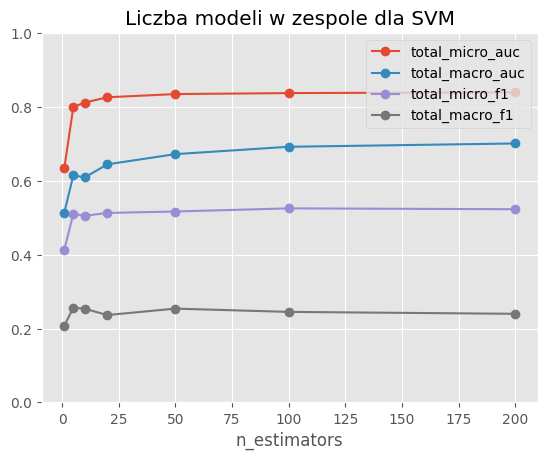

In [20]:
total_metrics = pd.DataFrame()
n_estimators_arr = [1,5,10,20,50,100,150]
for n_estimators in tqdm(n_estimators_arr):
    model = CustomBaggingClassifier(estimator=LinearSVC,
                            sample_size=1,
                            sample_size_features=1,
                            sampling_with_replacement_features=False,
                            sampling_with_replacement=False,
                            n_estimators=n_estimators,
                            categorical_features=categorical_columns,
                            estimator_kwargs={'loss': 'squared_hinge', 'C': 100})
    metrics = get_train_test_metrics(model, X_train, X_test, y_train, y_test)
    total_metrics = pd.concat([total_metrics, metrics])

plt.figure()
for metric in ['total_micro_auc','total_macro_auc','total_micro_f1','total_macro_f1']:
    plt.plot(n_estimators_arr, total_metrics[metric], '-o', label=metric)
plt.legend(loc='best')
plt.xlabel("n_estimators")
plt.title("Liczba modeli w zespole dla SVM")
plt.ylim([0,1])

Zwiększanie liczby modeli w zespole powyżej 100 nie przynosi poprawy. Jako wartość optymalną wybrano 100 do dalszych eksperymentów.

Wpływ wielkości losowanej próby na wyniki klasyfikacji dla modelu SVM i zbioru danych Wine Quality

100%|██████████| 5/5 [04:05<00:00, 49.03s/it]


(0.0, 1.0)

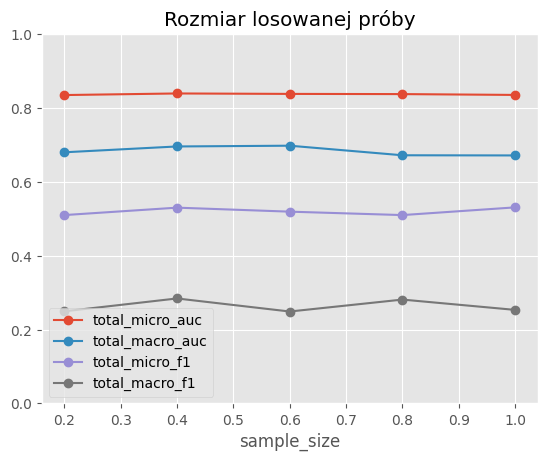

In [21]:
total_metrics = pd.DataFrame()
sample_size_arr = [0.2, 0.4, 0.6, 0.8, 1]
for sample_size in tqdm(sample_size_arr):
    model = CustomBaggingClassifier(estimator=LinearSVC,
                            sample_size=sample_size,
                            sample_size_features=1,
                            sampling_with_replacement_features=False,
                            sampling_with_replacement=False,
                            n_estimators=100,
                            categorical_features=categorical_columns,
                            estimator_kwargs={'loss': 'squared_hinge', 'C': 100})
    metrics = get_train_test_metrics(model, X_train, X_test, y_train, y_test)
    total_metrics = pd.concat([total_metrics, metrics])

plt.figure()
for metric in ['total_micro_auc','total_macro_auc','total_micro_f1','total_macro_f1']:
    plt.plot(sample_size_arr, total_metrics[metric], '-o', label=metric)
plt.legend(loc='best')
plt.xlabel("sample_size")
plt.title("Rozmiar losowanej próby")
plt.ylim([0,1])

Rozmiar losowanej próby nie ma dużego wpływu na wyniki. Jako wartość optymalną wybrano 0.4.

Wpływ liczby losowanych atrybutów na wyniki klasyfikacji dla modelu SVM i zbioru danych Wine Quality

100%|██████████| 5/5 [02:14<00:00, 26.81s/it]


(0.0, 1.0)

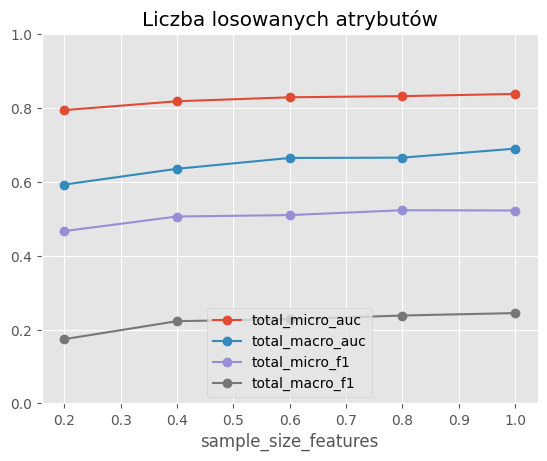

In [22]:
total_metrics = pd.DataFrame()
sample_size_features_arr = [0.2, 0.4, 0.6, 0.8, 1]
for sample_size_features in tqdm(sample_size_features_arr):
    model = CustomBaggingClassifier(estimator=LinearSVC,
                            sample_size=0.4,
                            sample_size_features=sample_size_features,
                            sampling_with_replacement_features=False,
                            sampling_with_replacement=False,
                            n_estimators=100,
                            categorical_features=categorical_columns,
                            estimator_kwargs={'loss': 'squared_hinge', 'C': 100})
    metrics = get_train_test_metrics(model, X_train, X_test, y_train, y_test)
    total_metrics = pd.concat([total_metrics, metrics])

plt.figure()
for metric in ['total_micro_auc','total_macro_auc','total_micro_f1','total_macro_f1']:
    plt.plot(sample_size_features_arr, total_metrics[metric], '-o', label=metric)
plt.legend(loc='best')
plt.xlabel("sample_size_features")
plt.title("Liczba losowanych atrybutów")
plt.ylim([0,1])

Jakość modelu zwiększa sie przy zwiększaniu liczby atrybutów. Najlepsze wyniki uzyskuje się dla wszystkich atrybutów. Przyjęto więc parameetr sample_size_feature=1.0

Losowanie ze zwracaniem i bez zwracania dla modelu SVM i zbioru danych Wine Quality

In [23]:
total_metrics = pd.DataFrame()
replacements_arr = [{'samples': True, 'features': True},
                   {'samples': False, 'features': True},
                   {'samples': True, 'features': False},
                   {'samples': False, 'features': False}
                   ]
for replacements in tqdm(replacements_arr):
    model = CustomBaggingClassifier(estimator=LinearSVC,
                            sample_size=0.4,
                            sample_size_features=1,
                            sampling_with_replacement_features=replacements['features'],
                            sampling_with_replacement=replacements['samples'],
                            n_estimators=100,
                            categorical_features=categorical_columns,
                            estimator_kwargs={'loss': 'squared_hinge', 'C': 100})
    metrics = get_train_test_metrics(model, X_train, X_test, y_train, y_test)
    total_metrics = pd.concat([total_metrics, metrics])

100%|██████████| 4/4 [01:57<00:00, 29.26s/it]


(0.0, 1.3)

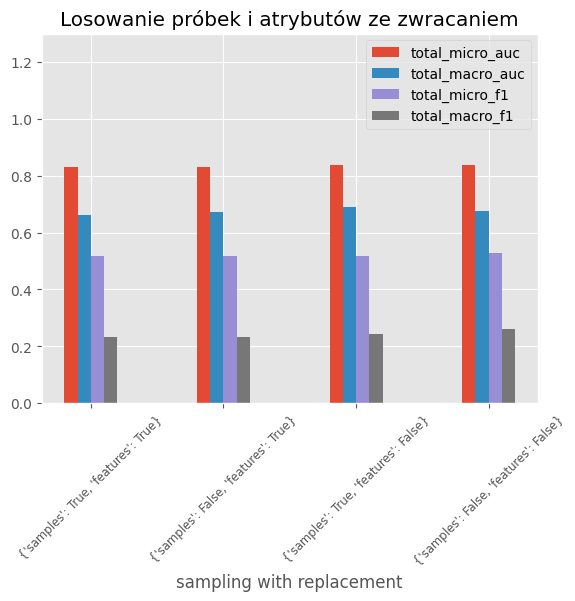

In [25]:
plt.figure()
for i, metric in enumerate(['total_micro_auc','total_macro_auc','total_micro_f1','total_macro_f1']):
    plt.bar(np.array(range(len(replacements_arr))) + i*0.1, total_metrics[metric], label=metric, width=0.1)
plt.legend(loc='best')
plt.xlabel("sampling with replacement")
plt.xticks(np.array(range(len(replacements_arr)))+0.15, [str(replacements) for replacements in replacements_arr], size='small', rotation=45)
plt.title("Losowanie próbek i atrybutów ze zwracaniem")
plt.ylim([0,1.3])

In [29]:
total_metrics['method'] = [str(rep) for rep in replacements_arr]
total_metrics

,total_micro_auc,total_macro_auc,total_micro_f1,total_macro_f1,sum,method
0,0.831385,0.661895,0.516628,0.231852,2.241760,"{'samples': True, 'features': True}"
0,0.831097,0.670950,0.516628,0.232758,2.251433,"{'samples': False, 'features': True}"
0,0.836045,0.690328,0.515855,0.243364,2.285592,"{'samples': True, 'features': False}"
0,0.836906,0.676951,0.528229,0.259653,2.301738,"{'samples': False, 'features': False}"


Losowanie bez zwracania i ze zwracaniem nie ma duzego wpływu na jakość modelu w przypadku atrybutów i próbek. Losowanie bez zwracania zarówno dla atrybutów jak i próbek daje minimalnie lepsze rezultaty, dlatego takie parametry przyjęto w dalszej części.

Finalna ewaluacja zespołu modeli - grid search z k-krotną walidacją po parametrach SVM dla wyznaczonych wcześniej parametrów metodyki Bagging.

In [30]:
grid = [{'loss': ['hinge', 'squared_hinge'], 'C': [0.01, 0.1, 1, 10, 100, 1000]}]
sklearn_grid = ParameterGrid(grid)
total_metrics = pd.DataFrame()

for param_grid in tqdm(sklearn_grid):
    model = CustomBaggingClassifier(estimator=LinearSVC,
                                    sample_size=0.4,
                                    sample_size_features=1,
                                    sampling_with_replacement_features=False,
                                    sampling_with_replacement=False,
                                    n_estimators=100,
                                    categorical_features=categorical_columns,
                                    estimator_kwargs=param_grid)
    metrics = get_k_fold_metrics(model, splits=5, X=X, y=y)
    row = pd.concat([pd.DataFrame([param_grid]), metrics], axis=1)
    total_metrics = pd.concat([total_metrics, row])

total_metrics.sort_values(by='sum')

100%|██████████| 12/12 [17:36<00:00, 88.04s/it] 


,C,loss,total_micro_auc,total_macro_auc,total_micro_f1,total_macro_f1,sum
0,0.01,hinge,0.758409,0.585767,0.509902,0.231148,2.085226
0,10.00,hinge,0.760782,0.631970,0.493187,0.222836,2.108775
0,1.00,hinge,0.766523,0.644830,0.491021,0.221468,2.123841
0,0.10,hinge,0.772595,0.648278,0.488390,0.223843,2.133107
0,0.01,squared_hinge,0.762029,0.590489,0.532499,0.248258,2.133275
0,0.10,squared_hinge,0.765458,0.594597,0.530795,0.249595,2.140446
0,1.00,squared_hinge,0.766086,0.594876,0.532034,0.251335,2.144331
0,10.00,squared_hinge,0.772732,0.598725,0.529712,0.249868,2.151037
0,100.00,hinge,0.828436,0.661304,0.529248,0.241965,2.260953
0,100.00,squared_hinge,0.843749,0.698217,0.533735,0.262575,2.338275


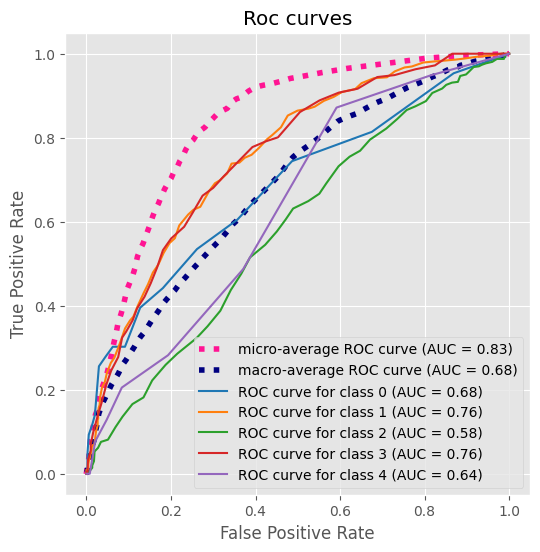

In [37]:
model = CustomBaggingClassifier(estimator=LinearSVC,
                        sample_size=0.4,
                        sample_size_features=1,
                        sampling_with_replacement_features=False,
                        sampling_with_replacement=False,
                        n_estimators=100,
                        categorical_features=categorical_columns,
                        estimator_kwargs={'loss': 'squared_hinge', 'C': 1000})
model.fit(X_train, y_train)
y_pred = model.predict(X_test, predict_proba=True)
plot_roc(y_pred, y_test, model.n_classes)

Analogiczny grid search, ale tym razem dla pojedynczgo modelu SVM

In [34]:
grid = [{'loss': ['hinge', 'squared_hinge'], 'C': [0.01, 0.1, 1, 10, 100, 1000]}]
sklearn_grid = ParameterGrid(grid)
total_metrics = pd.DataFrame()

for param_grid in tqdm(sklearn_grid):
    model = CustomBaggingClassifier(estimator=LinearSVC,
                                    sample_size=1,
                                    sample_size_features=1,
                                    sampling_with_replacement_features=False,
                                    sampling_with_replacement=False,
                                    n_estimators=1,
                                    categorical_features=categorical_columns,
                                    estimator_kwargs=param_grid)
    metrics = get_k_fold_metrics(model, splits=5, X=X, y=y)
    row = pd.concat([pd.DataFrame([param_grid]), metrics], axis=1)
    total_metrics = pd.concat([total_metrics, row])

total_metrics.sort_values(by='sum')

100%|██████████| 12/12 [00:30<00:00,  2.54s/it]


,C,loss,total_micro_auc,total_macro_auc,total_micro_f1,total_macro_f1,sum
0,1000.00,squared_hinge,0.612448,0.527508,0.379917,0.207400,1.727273
0,10.00,hinge,0.625218,0.541075,0.400349,0.219402,1.786044
0,1000.00,hinge,0.634787,0.536155,0.415659,0.241506,1.828108
0,1.00,hinge,0.648334,0.558374,0.437334,0.235888,1.879929
0,100.00,hinge,0.660904,0.537874,0.457447,0.233397,1.889622
0,0.10,hinge,0.663223,0.551653,0.461156,0.231629,1.907661
0,0.01,hinge,0.672216,0.546926,0.475546,0.216924,1.911613
0,100.00,squared_hinge,0.669798,0.571637,0.471677,0.287156,2.000268
0,0.01,squared_hinge,0.707424,0.558790,0.531879,0.248103,2.046195
0,1.00,squared_hinge,0.707908,0.559627,0.532652,0.251093,2.051280


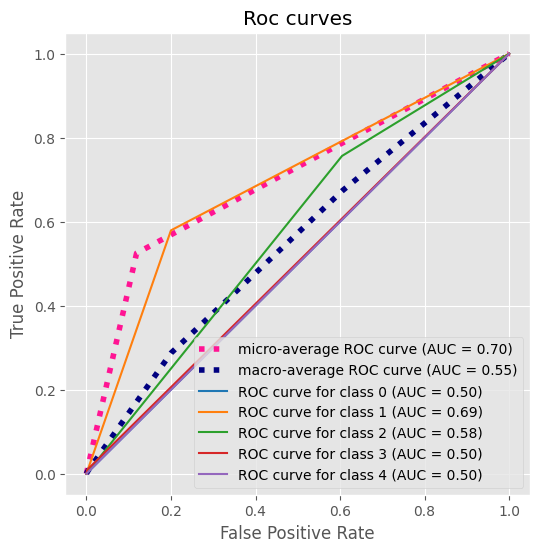

In [38]:
model = CustomBaggingClassifier(estimator=LinearSVC,
                        sample_size=1,
                        sample_size_features=1,
                        sampling_with_replacement_features=False,
                        sampling_with_replacement=False,
                        n_estimators=1,
                        categorical_features=categorical_columns,
                        estimator_kwargs={'loss': 'squared_hinge', 'C': 10})
model.fit(X_train, y_train)
y_pred = model.predict(X_test, predict_proba=True)
plot_roc(y_pred, y_test, model.n_classes)

#### Eksperymenty modelem Logistic Regression jako modelem bazowym do zespołu

Najpierw przeprowadzany jest prosty grid search, żeby znaleźć dobrze działający zestaw parametrów Logistic Regression do dalszych eksperymentów.

In [40]:
grid = [{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}]
sklearn_grid = ParameterGrid(grid)
total_metrics = pd.DataFrame()

for param_grid in tqdm(sklearn_grid):
    model = CustomBaggingClassifier(estimator=LogisticRegression,
                                    sample_size=1,
                                    sample_size_features=1,
                                    sampling_with_replacement_features=False,
                                    sampling_with_replacement=False,
                                    n_estimators=5,
                                    categorical_features=categorical_columns,
                                    estimator_kwargs=param_grid)
    metrics = get_k_fold_metrics(model, splits=5, X=X, y=y)
    row = pd.concat([pd.DataFrame([param_grid]), metrics], axis=1)
    total_metrics = pd.concat([total_metrics, row])

total_metrics.sort_values(by='sum')

100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


,C,total_micro_auc,total_macro_auc,total_micro_f1,total_macro_f1,sum
0,0.001,0.838285,0.722307,0.524759,0.234860,2.320210
0,0.010,0.850944,0.747384,0.543486,0.286245,2.428059
0,0.100,0.853659,0.756801,0.543795,0.299373,2.453628
0,100.000,0.853735,0.757572,0.545033,0.303830,2.460170
0,1000.000,0.853734,0.757585,0.545033,0.303830,2.460182
0,10.000,0.853739,0.757582,0.545033,0.303830,2.460185
0,1.000,0.853747,0.757576,0.545343,0.303799,2.460464


Model wybrany do dalszych eksperymentów: C=1000

Wpływ liczby modeli w zespole na wyniki klasyfikacji dla modelu SVM i zbioru danych Wine Quality

100%|██████████| 7/7 [00:21<00:00,  3.06s/it]


(0.0, 1.0)

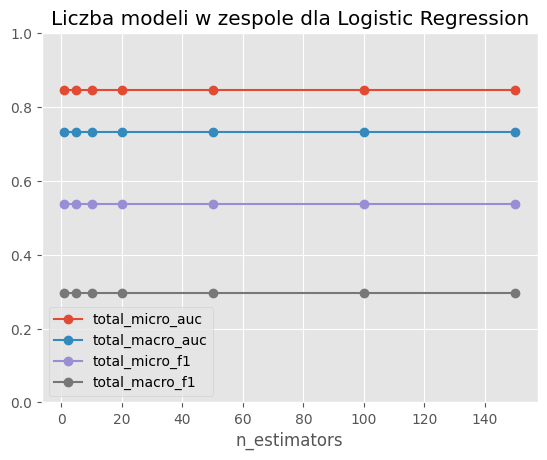

In [41]:
total_metrics = pd.DataFrame()
n_estimators_arr = [1,5,10,20,50,100,150]
for n_estimators in tqdm(n_estimators_arr):
    model = CustomBaggingClassifier(estimator=LogisticRegression,
                            sample_size=1,
                            sample_size_features=1,
                            sampling_with_replacement_features=False,
                            sampling_with_replacement=False,
                            n_estimators=n_estimators,
                            categorical_features=categorical_columns,
                            estimator_kwargs={'C': 1000})
    metrics = get_train_test_metrics(model, X_train, X_test, y_train, y_test)
    total_metrics = pd.concat([total_metrics, metrics])

plt.figure()
for metric in ['total_micro_auc','total_macro_auc','total_micro_f1','total_macro_f1']:
    plt.plot(n_estimators_arr, total_metrics[metric], '-o', label=metric)
plt.legend(loc='best')
plt.xlabel("n_estimators")
plt.title("Liczba modeli w zespole dla Logistic Regression")
plt.ylim([0,1])

### Analogiczne eksperymenty na zbiorze Adult dataset

#### Eksperymenty z modelem SVM jako bazowym modelem do zespołu

#### Eksperymenty z modelem Logistic Regression jako bazowym modelem do zespołu

#### Eksperymenty z modelem Decision Tree jako bazowym modelem do zespołu

# Podsumowanie